In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from difflib import SequenceMatcher as SM
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import datetime
import cPickle as pickle

%matplotlib inline

In [107]:
def convert_unix_timestamp(df, column_name):
    df[column_name] = df[column_name].map(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [160]:
def add_dummies(df, column_name, baseline):
    dummies = pd.get_dummies(df[column_name])
    if column_name == 'payout_type':
        dummies.rename(columns={'': 'BLANK'}, inplace=True)
    dummies.drop(baseline, axis=1, inplace=True)
    df.drop(column_name, axis=1, inplace=True)
    return pd.concat((df, dummies), axis=1)

In [161]:
def length_of_feature(df, column_name, length_col_name, drop_orig=True):
    df[length_col_name] = map(lambda x: len(x), df[column_name])
    if drop_orig == True:
        df.drop(column_name, axis=1, inplace=True)

In [162]:
def smote(X, y, minority_weight=.5):
    '''
    generates new observations in minority class
    so that output X, y have specified percentage of majority observations
    '''
    # compute number of new examples required
    class_ratio = y.sum()/float(len(y))
    majority_class_label = round(class_ratio)
    X_minority = X[y!=majority_class_label]
    y_minority = y[y!=majority_class_label]
    min_count = len(X_minority)
    maj_count = len(X) - min_count
    scaling_factor = (maj_count/float(min_count))*(minority_weight/(1-minority_weight))
    new_observations_target = round(scaling_factor*min_count) - min_count

    # train KNN
    knn_model = KNeighborsClassifier(n_neighbors=int(round(len(X_minority)**.5)))
    knn_model.fit(X_minority, y_minority)
    if new_observations_target < len(X_minority):
        sample_indices = np.random.choice(xrange(X_minority), 
                                          size=new_observations_target,
                                          replace=False)
        smote_samples = X_minority[sample_indices]
    else:
        smote_samples = X_minority
    neighbors = knn_model.kneighbors(smote_samples)[1]
    
    # generate new samples
    new_observations = np.empty((0,X.shape[1]))
    while len(new_observations) < new_observations_target:
        index = len(new_observations) % len(smote_samples)
        neighbor_index = np.random.choice(neighbors[index])
        neighbor = smote_samples[neighbor_index]
        x = X_minority[index]
        new_x = x + (neighbor - x)*np.random.random(size=X_minority.shape[1])
        new_observations = np.vstack((new_observations, new_x))
    minority_class_label = (majority_class_label + 1) % 2
    X = np.vstack((X, new_observations))
    y = np.hstack((y, np.array([minority_class_label]*len(new_observations))))
    
    return X, y

In [195]:
def feature_importance(model, dfX, dfy):
    fi = model.feature_importances_
    yticks = X_top.columns[np.argsort(fi)].values
    fi = sorted(fi)
    x = xrange(len(yticks))
    plt.figure(figsize=(15, 15))
    plt.barh(x, fi)
    plt.yticks(x, yticks)
    plt.tight_layout()

## Read in data

In [164]:
df = pd.read_json('train_new.json')

In [165]:
# Find rows that are fraudulent
frauds = df['acct_type'].str.contains('fraudster')

In [166]:
df['fraud'] = frauds

In [46]:
#convert_unix_timestamp(df, 'event_created')
#convert_unix_timestamp(df, 'event_start')
#convert_unix_timestamp(df, 'event_end')
# Filling empty values
#df['event_published'] = df['event_published'].fillna(1352831618)
#convert_unix_timestamp(df, 'event_published')

#convert_unix_timestamp(df, 'user_created')

In [167]:
# Countries dummies ('US' as baseline)
df = add_dummies(df, 'country', 'US')
# Currency dummies ('USD' as baseline)
df = add_dummies(df, 'currency', 'USD')
# Payouts dummies ('ACH' as baseline)
df = add_dummies(df, 'payout_type', 'ACH')

In [168]:
length_of_feature(df, 'description', 'len_desc')
length_of_feature(df, 'previous_payouts', 'len_pp')
length_of_feature(df, 'org_desc', 'len_org_desc')
length_of_feature(df, 'ticket_types', 'len_tt')

In [169]:
df['has_header'] = df['has_header'].fillna(2)
df['venue_latitude'] = df['venue_latitude'].fillna(0.)
df['venue_longitude'] = df['venue_longitude'].fillna(0.)
df['sale_duration'] = df['sale_duration'].fillna(df['sale_duration'].mean())

In [170]:
df['org_facebook'] = df['org_facebook'].fillna(0)
df['org_twitter'] = df['org_twitter'].fillna(0)
df['event_published'] = df['event_published'].fillna(0)
df['delivery_method'] = df['delivery_method'].fillna(0)

In [171]:
df.drop(['venue_state', 'venue_name', 'venue_address'], axis=1, inplace=True)

In [172]:
sus_domains = ["gmail.com", "yahoo.com", "hotmail.com", "ymail.com","aol.com", \
               "lidf.co.uk"," live.com", "live.fr", "yahoo.co.uk", "rocketmail.com"]
df['sus_domain'] = map(lambda x: True if x in sus_domains else False, df['email_domain'])
df.drop(['email_domain'], axis=1, inplace=True)

In [173]:
def fuzzy(x):
    return SM(None, x['org_name'], x['payee_name']).ratio()

df['fuzzy_sim'] = df.apply(fuzzy, axis=1)

In [174]:
df.drop(['name', 'org_name', 'payee_name'], axis=1, inplace=True)

In [175]:
df.drop(['acct_type', 'venue_country'], axis=1, inplace=True)
df['listed'] = df['listed'].map({'y': 1, 'n': 0})

In [176]:
y = df['fraud']
X = df.drop('fraud', axis=1)

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [178]:
X_smoted, y_smoted = smote(X_train.values, y_train.values, minority_weight=.3)

## Fitting Random Forest with SMOTE

In [179]:
rf = RandomForestClassifier()
rf.fit(X_smoted, y_smoted)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

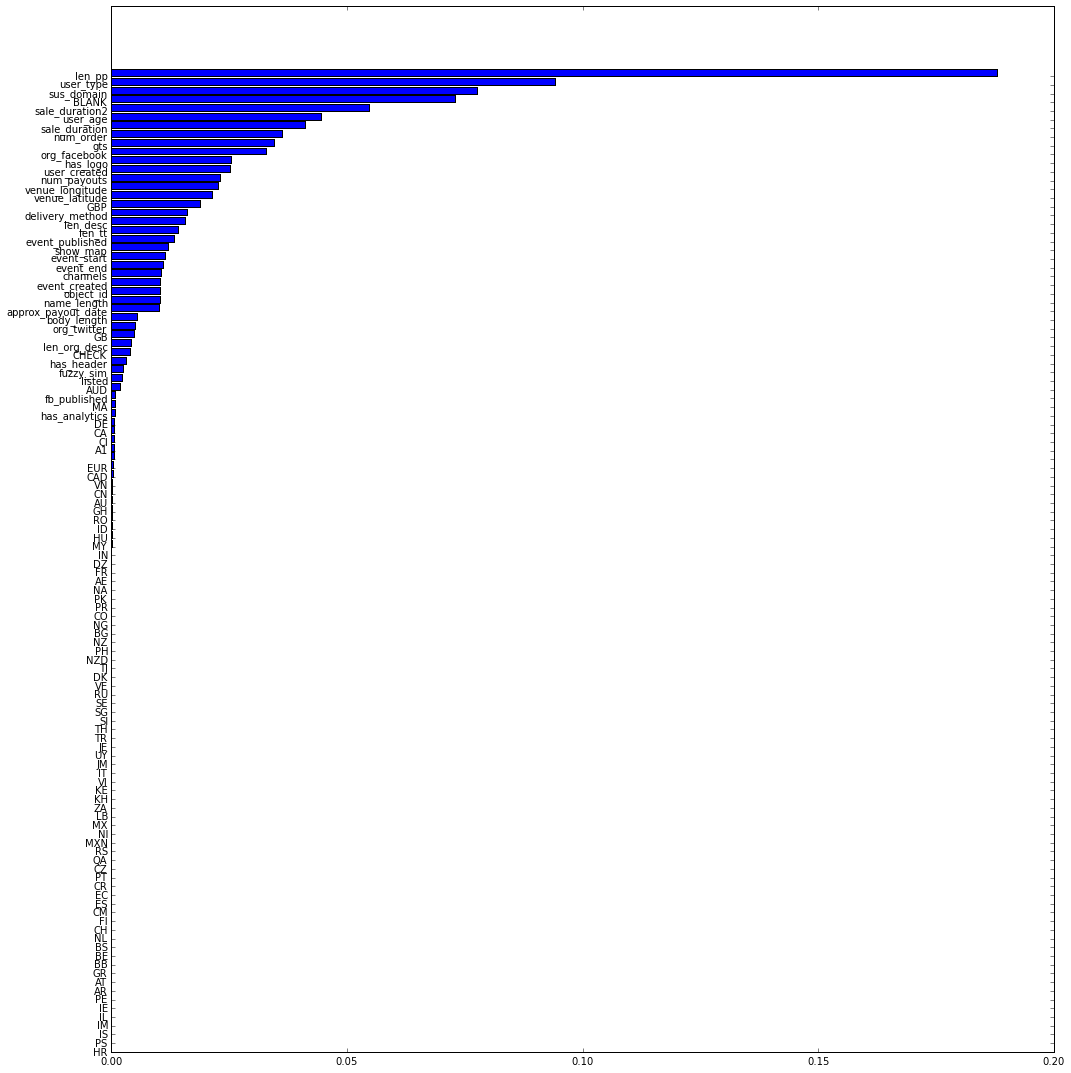

In [181]:
feature_importance(rf, X_smoted, y_smoted)

In [182]:
rf.score(X_smoted, y_smoted)

0.99959731543624164

In [183]:
y_pred = rf.predict(X_test)
y_pred_smote = rf.predict(X_smoted)

In [184]:
confusion_matrix(y_test, y_pred)

array([[2608,    6],
       [  31,  223]])

In [185]:
confusion_matrix(y_smoted, y_pred_smote)

array([[10429,     1],
       [    5,  4465]])

In [186]:
tpr = 2608. / (2614 + 31)
print "Accuracy Score: ", rf.score(X, y)
print "True Positive Rate: ", tpr

Accuracy Score:  0.997070516845
True Positive Rate:  0.986011342155


### Random Forest on Top 20 Features

In [187]:
yticks = X.columns[np.argsort(rf.feature_importances_)].values
features = yticks[-20:]

In [188]:
print features

[u'event_published' 'len_tt' 'len_desc' u'delivery_method' u'GBP'
 u'venue_latitude' u'venue_longitude' u'num_payouts' u'user_created'
 u'has_logo' u'org_facebook' u'gts' u'num_order' u'sale_duration'
 u'user_age' u'sale_duration2' 'BLANK' 'sus_domain' u'user_type' 'len_pp']


In [189]:
X_top = X[features]

In [190]:
X_top.head()

,event_published,len_tt,len_desc,delivery_method,GBP,venue_latitude,venue_longitude,num_payouts,user_created,has_logo,org_facebook,gts,num_order,sale_duration,user_age,sale_duration2,BLANK,sus_domain,user_type,len_pp
0,1263109838,3,3687,0,0,25.777471,-80.133433,0,1259613950,0,0,0.00,0,29,36,33,1,True,1,0
1,1293833295,2,3499,1,0,32.776566,-79.930922,1,1280942776,1,0,868.02,23,28,149,28,0,False,3,49
2,1291091908,1,2601,1,0,33.944201,-118.080419,4,1272559388,0,0,3500.00,19,54,214,54,0,False,3,36
3,1360683446,6,12347,1,0,0.000000,0.000000,16,1283870102,1,0,1167.35,39,0,889,0,0,False,3,21
4,1291994966,8,2417,0,0,42.353848,-71.044276,0,1288984065,0,0,2313.15,30,63,35,63,0,False,3,49


In [191]:
X_top_train, X_top_test, y_train, y_test = train_test_split(X_top, y, test_size=0.20, random_state=42)

In [192]:
X_top_smoted, y_top_smoted = smote(X_top_train.values, y_train.values, minority_weight=.3)

In [193]:
rf_top = RandomForestClassifier()
rf_top.fit(X_top_smoted, y_top_smoted)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [194]:
rf_top.score(X_top_test, y_test)

0.98675034867503486

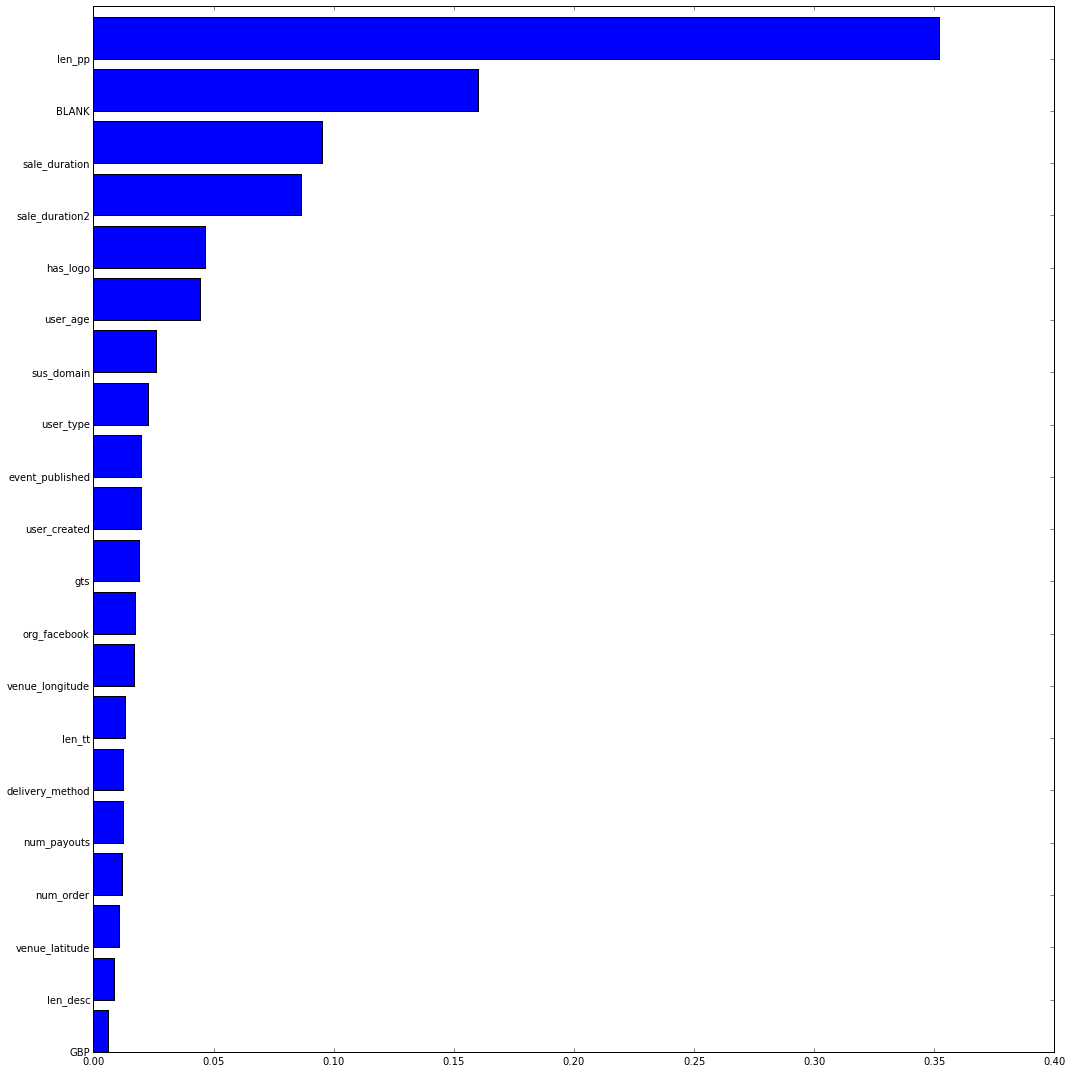

In [196]:
feature_importance(rf_top, X_top_smoted, y_smoted)

In [197]:
y_top_pred = rf_top.predict(X_top_test)

In [198]:
confusion_matrix(y_test, y_top_pred)

array([[2600,   14],
       [  24,  230]])

In [204]:
tpr = 2600. / (2600 + 24)
print "Accuracy Score: ", rf_top.score(X_top_test, y_test)
print "True Positive Rate: ", tpr

Accuracy Score:  0.986750348675
True Positive Rate:  0.990853658537


In [199]:
rf_top.predict_proba(X_top_test)

array([[ 1. ,  0. ],
       [ 1. ,  0. ],
       [ 0. ,  1. ],
       ..., 
       [ 1. ,  0. ],
       [ 0.9,  0.1],
       [ 1. ,  0. ]])

### Pickling RandomForest Model

In [200]:
with open('random_forest.pkl', 'w') as f:
    pickle.dump(rf_top, f)

## Trying Other Models

In [220]:
# Grid Search on SVM
parameters = {'kernel':['rbf'], 'C':[1, 0.1]}
svm = SVC()
gs = GridSearchCV(svm, parameters, scoring='recall')

In [221]:
gs.fit(X_top_smoted, y_top_smoted)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'kernel': ['rbf'], 'C': [1, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='recall', verbose=0)

In [222]:
svc = gs.best_estimator_

In [226]:
svc.score(X_top_test, y_test)

0.91248256624825663

In [224]:
y_svc_pred = svc.predict(X_top_test)

In [225]:
confusion_matrix(y_test, y_svc_pred)

array([[2614,    0],
       [ 251,    3]])

In [205]:
# Grid Search on GBR
gradient_boosting_grid = {'learning_rate':[0.01, 0.05, 0.1, 0.5], 
                          'max_depth': [1, 3, 5, 7],
                          'min_samples_leaf': [1, 2, 4, 6],
                          'n_estimators': [20, 100, 200]}
gbr = GradientBoostingClassifier()
gs_gbr = GridSearchCV(gbr, gradient_boosting_grid, scoring='recall')

In [210]:
gs_gbr.fit(X_top_smoted, y_top_smoted)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_estimators': [20, 100, 200], 'learning_rate': [0.01, 0.05, 0.1, 0.5], 'max_depth': [1, 3, 5, 7], 'min_samples_leaf': [1, 2, 4, 6]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='recall', verbose=0)

In [211]:
gs_gbr.best_params_

{'learning_rate': 0.05,
 'max_depth': 7,
 'min_samples_leaf': 6,
 'n_estimators': 200}

In [212]:
gs_gbr.best_score_

0.97382406197919014

In [213]:
gbr = gs_gbr.best_estimator_

In [214]:
y_top_pred = gbr.predict(X_top_test)

In [215]:
gbr.score(X_top_test, y_test)

0.9884937238493724

In [216]:
confusion_matrix(y_test, y_top_pred)

array([[2603,   11],
       [  22,  232]])

In [217]:
tpr = 2603. / (2603 + 22)
print "Accuracy Score: ", gbr.score(X_top_test, y_test)
print "True Positive Rate: ", tpr

Accuracy Score:  0.988493723849
True Positive Rate:  0.991619047619
